<a href="https://colab.research.google.com/github/AAA123404/Financial-big-data-analysis/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install yfinance

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

# 股票代碼
top8_tickers = [
    "2330.TW",  # 台積電
    "2317.TW",  # 鴻海
    "2454.TW",  # 聯發科
    "2881.TW",  # 富邦金
    "2382.TW",  # 廣達
    "2308.TW",  # 台達電
    "2882.TW",  # 國泰金
    "2412.TW",  # 中華電
]

# 時間範圍
start_date_train = "2019-01-01"
end_date_train = "2024-01-01"

# 下載股票資料
def download_data(tickers, start, end):
    all_data = pd.DataFrame()
    for ticker in tickers:
        data = yf.download(ticker, start=start, end=end)
        data['Daily Return'] = data['Adj Close'].pct_change()
        all_data[ticker] = data['Daily Return']
    return all_data.dropna()

train_data = download_data(top8_tickers, start_date_train, end_date_train)

# 平均日收益率與波動率
mean_returns = train_data.mean()
volatilities = train_data.std()
correlation_matrix = train_data.corr()

print("\n📈 台灣市值前8大公司平均日收益率：")
print(mean_returns)
print("\n📊 台灣市值前8大公司波動率：")
print(volatilities)
print("\n🔗 相關係數矩陣：")
print(correlation_matrix)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 台灣市值前8大公司平均日收益率：
2330.TW    0.001070
2317.TW    0.000642
2454.TW    0.001764
2881.TW    0.000717
2382.TW    0.001646
2308.TW    0.001018
2882.TW    0.000279
2412.TW    0.000273
dtype: float64

📊 台灣市值前8大公司波動率：
2330.TW    0.016683
2317.TW    0.015485
2454.TW    0.023347
2881.TW    0.013792
2382.TW    0.019021
2308.TW    0.018140
2882.TW    0.012954
2412.TW    0.006524
dtype: float64

🔗 相關係數矩陣：
          2330.TW   2317.TW   2454.TW   2881.TW   2382.TW   2308.TW   2882.TW  \
2330.TW  1.000000  0.429375  0.512504  0.433609  0.332982  0.497577  0.446084   
2317.TW  0.429375  1.000000  0.357573  0.405208  0.302451  0.362452  0.431668   
2454.TW  0.512504  0.357573  1.000000  0.309796  0.241876  0.357710  0.331443   
2881.TW  0.433609  0.405208  0.309796  1.000000  0.266516  0.375953  0.831171   
2382.TW  0.332982  0.302451  0.241876  0.266516  1.000000  0.314661  0.248767   
2308.TW  0.497577  0.362452  0.357710  0.375953  0.314661  1.000000  0.363112   
2882.TW  0.446084  0.431668  0.3314

In [ ]:
# === 參數設定 ===
POPULATION_SIZE = 30  # 初始族群數量
GENERATIONS = 100    # 演化代數
MUTATION_RATE = 0.1   # 突變率
SHARPE_WEIGHT = 0.5  # 夏普比率權重
MAX_DRAWDOWN_WEIGHT = 0.5  # 最大回撤權重

# === 初始化族群 ===
def initialize_population(size, num_stocks=8):
    return [np.random.dirichlet(np.ones(num_stocks)).tolist() for _ in range(size)]

# === 選擇機制 ===
def roulette_wheel_selection(population, fitness_values):
    total_fitness = sum(fitness_values)
    if total_fitness == 0:
        probabilities = [1 / len(fitness_values)] * len(fitness_values)
    else:
        probabilities = [f / total_fitness for f in fitness_values]
    return random.choices(population, probabilities, k=2)

def rank_selection(population, fitness_values):
    sorted_population = [x for _, x in sorted(zip(fitness_values, population), reverse=True)]
    ranks = np.arange(1, len(sorted_population) + 1)
    probabilities = ranks / ranks.sum()
    return random.choices(sorted_population, probabilities, k=2)

# === 交配 ===
def crossover(parent1, parent2):
    point = random.randint(1, len(parent1) - 2)  # 避免完全複製父代
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    # 確保子代權重總和為1
    child1 = [w / sum(child1) for w in child1]
    child2 = [w / sum(child2) for w in child2]
    return child1, child2

# === 突變 ===
def mutate(chromosome):
    for i in range(len(chromosome)):
        if random.random() < MUTATION_RATE:
            chromosome[i] = abs(chromosome[i] + np.random.normal(0, 0.1))
    return normalize(chromosome)  # 確保每次突變後權重總和為1

# 正規化
def normalize(chromosome):
    total = sum(chromosome)
    return [w / total for w in chromosome]

# === 適應度函數 ===
def sharpe_ratio(weights):
    weights = np.array(weights)  # 確保是 NumPy 陣列
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(train_data.cov(), weights)))
    if portfolio_volatility == 0:
        return float('-inf')
    return portfolio_return / portfolio_volatility


def max_drawdown(weights):
    weights = np.array(weights)  # 確保是 NumPy 陣列
    portfolio_returns = (train_data @ weights).dropna()
    cumulative_return = (1 + portfolio_returns).cumprod()
    peak = cumulative_return.cummax()
    drawdown = (cumulative_return - peak) / peak
    return drawdown.min()


def fitness(chromosome):
    if not np.isclose(sum(chromosome), 1):
        return float('-inf')
    sharpe = sharpe_ratio(np.array(chromosome))
    mdd = max_drawdown(np.array(chromosome))
    if np.isnan(mdd) or np.isnan(sharpe) or np.isinf(sharpe):
        return float('-inf')

    return SHARPE_WEIGHT * sharpe - MAX_DRAWDOWN_WEIGHT * mdd

def visualize_weights(best_chromosome):
    plt.figure(figsize=(12, 6))
    plt.bar(top8_tickers, best_chromosome)
    plt.title('Optimal Portfolio Weights')
    plt.xlabel('Stock Ticker')
    plt.ylabel('Weight')
    plt.show()



✅ 最佳投資組合權重:
2330.TW: 0.17
2317.TW: 0.03
2454.TW: 0.35
2881.TW: 0.06
2382.TW: 0.05
2308.TW: 0.01
2882.TW: 0.25
2412.TW: 0.09

📊 最佳適應度分數: 0.22273357079033465


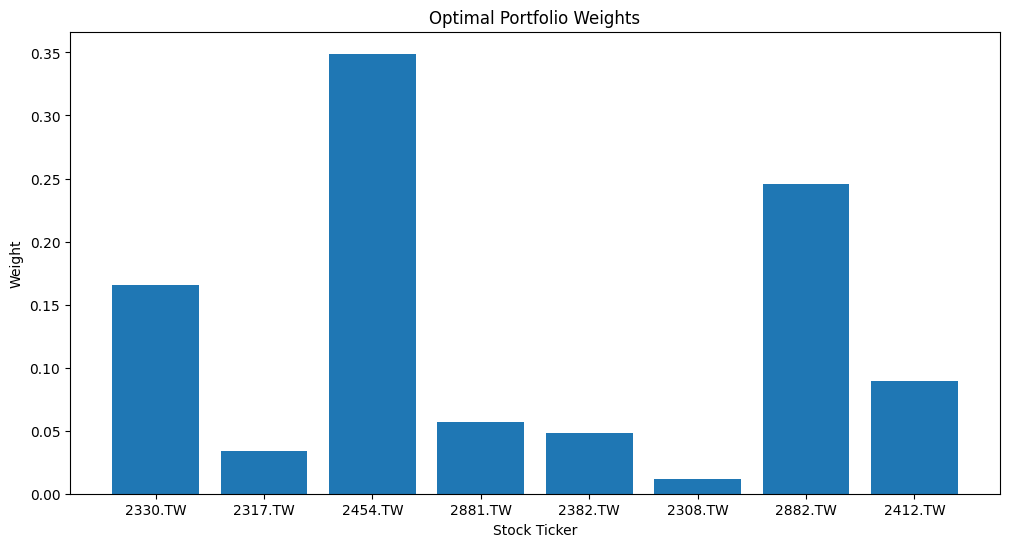

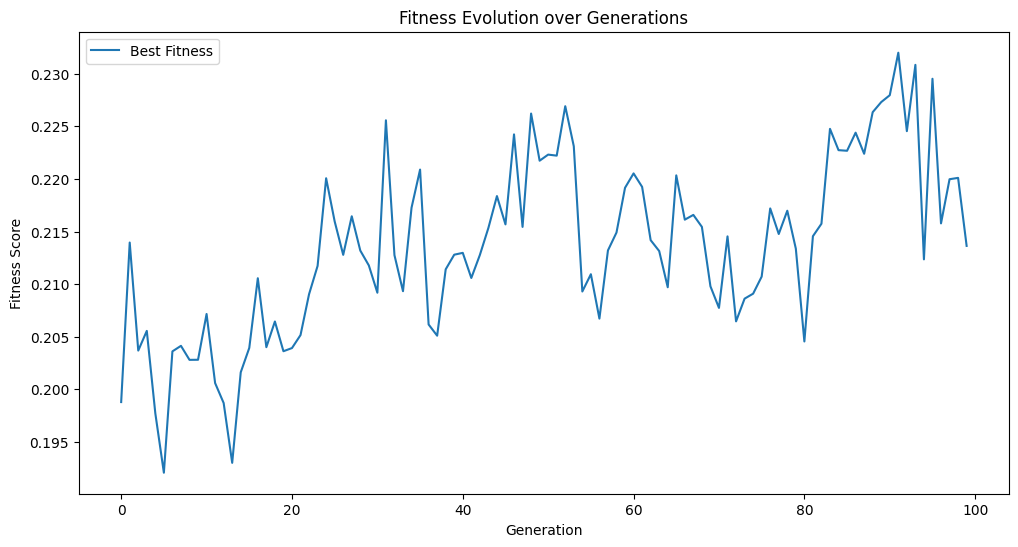

In [ ]:
# === 演算法主流程 ===
def genetic_algorithm():
    global best_chromosome  # 定義全域變數
    population = initialize_population(POPULATION_SIZE, num_stocks=8)
    fitness_history = []
    best_fitness = float('-inf')  # 初始化最佳適應度
    for generation in range(GENERATIONS):

        fitness_values = [fitness(chromosome) for chromosome in population]
        current_best_fitness = max(fitness_values)
        fitness_history.append(current_best_fitness)  # 記錄每代的最佳適應度

        # 選擇機制 - 修正父代選擇
        parents = []
        for _ in range(POPULATION_SIZE // 2):
            parent1, parent2 = roulette_wheel_selection(population, fitness_values)
            parents.append((parent1, parent2))


        # 生成新一代
        new_population = []
        for parent1, parent2 in parents:
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            new_population.extend([child1, child2])

        population = new_population

    # 找到最佳染色體
    fitness_values = [fitness(chromosome) for chromosome in population]
    best_index = np.argmax(fitness_values)
    best_chromosome = population[best_index]

    print("\n✅ 最佳投資組合權重:")
    for ticker, weight in zip(top8_tickers, best_chromosome):
        print(f"{ticker}: {weight:.2f}")
    print("\n📊 最佳適應度分數:", fitness_values[best_index])

    # 視覺化投資組合權重
    visualize_weights(best_chromosome)

    # 視覺化適應度趨勢
    plt.figure(figsize=(12, 6))
    plt.plot(fitness_history, label='Best Fitness')
    plt.title('Fitness Evolution over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Score')
    plt.legend()
    plt.show()

genetic_algorithm()

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# 定義股票代號和權重
tickers = ['2330.TW', '2317.TW', '2454.TW', '2881.TW', '2382.TW', '2308.TW', '2882.TW', '2412.TW']
weights = np.array([0.17, 0.03, 0.35, 0.06, 0.05, 0.01, 0.25, 0.09])

# 下載歷史價格數據
data = yf.download(tickers + ['0050.TW'], start='2024-01-01', end='2025-01-01')['Adj Close']

# 計算每日報酬率
returns = data.pct_change().dropna()

# 計算投資組合每日報酬率
portfolio_returns = returns[tickers].dot(weights)

# 計算年化報酬率
annual_return = portfolio_returns.mean() * 252
etf_annual_return = returns['0050.TW'].mean() * 252

# 計算年化標準差
annual_std = portfolio_returns.std() * np.sqrt(252)
etf_annual_std = returns['0050.TW'].std() * np.sqrt(252)

# 假設無風險利率為 1%
risk_free_rate = 0.01

# 計算夏普比率
sharpe_ratio = (annual_return - risk_free_rate) / annual_std
etf_sharpe_ratio = (etf_annual_return - risk_free_rate) / etf_annual_std

# 計算最大回撤
cumulative_returns = (1 + portfolio_returns).cumprod()
cumulative_max = cumulative_returns.cummax()
drawdown = cumulative_returns - cumulative_max
max_drawdown = drawdown.min()

etf_cumulative_returns = (1 + returns['0050.TW']).cumprod()
etf_cumulative_max = etf_cumulative_returns.cummax()
etf_drawdown = etf_cumulative_returns - etf_cumulative_max
etf_max_drawdown = etf_drawdown.min()

# 整理結果
results = pd.DataFrame({
    '指標': ['年化報酬率', '年化標準差', '夏普比率', '最大回撤'],
    '投資組合': [annual_return, annual_std, sharpe_ratio, max_drawdown],
    '元大台灣50 ETF': [etf_annual_return, etf_annual_std, etf_sharpe_ratio, etf_max_drawdown]
})

print(results)


[*********************100%***********************]  9 of 9 completed


      指標      投資組合  元大台灣50 ETF
0  年化報酬率  0.504980    0.450872
1  年化標準差  0.255020    0.251599
2   夏普比率  1.940945    1.752278
3   最大回撤 -0.337011   -0.327620
